In [ ]:
import pandas as pd
import numpy as np
from numpy import array
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error
# %matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
rpath = "/content/drive/MyDrive/UofT/grad/ece1508/Final_Project/sentiment_analysis/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Train and Validate model

In [ ]:
# Import dataset: we use Apple stock price from 2011 to 2017 as our dataset
df=pd.read_csv(rpath + 'Apple_Score.csv')
df

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume,sentiment_score
0,0,2006-12-01,13.114285,13.190000,12.871428,91.320000,13.045714,198769900,0.7707
1,1,2006-12-04,13.125714,13.150000,12.928572,91.120003,13.017143,177384200,0.8720
2,3,2006-12-06,12.948571,13.055715,12.810000,89.830002,12.832857,159546100,0.6858
3,4,2006-12-07,12.861428,12.928572,12.414286,87.040001,12.434286,251206900,-0.6712
4,5,2006-12-08,12.461429,12.770000,12.428572,88.259995,12.608571,196069300,-0.1796
...,...,...,...,...,...,...,...,...,...
2318,2508,2016-11-17,109.809998,110.349998,108.830002,109.949997,109.949997,27632000,0.9231
2319,2509,2016-11-18,109.720001,110.540001,109.660004,110.059998,110.059998,28428900,0.8640
2320,2510,2016-11-21,110.120003,111.989998,110.010002,111.730003,111.730003,29264600,-0.8201
2321,2511,2016-11-22,111.949997,112.419998,111.400002,111.800003,111.800003,25965500,-0.8885


In [ ]:
df = df[['Adj Close', 'sentiment_score']]
df.head()

,Adj Close,sentiment_score
0,13.045714,0.7707
1,13.017143,0.8720
2,12.832857,0.6858
3,12.434286,-0.6712
4,12.608571,-0.1796


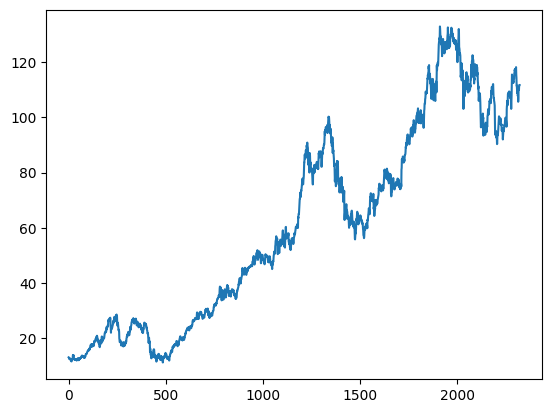

In [ ]:
plt.plot(df['Adj Close']);
plt.show()

In [ ]:
# Normalize the data using Min-Max scaling, ensuring that the values are scaled to fall within the range of 0 and 1.
scaler = MinMaxScaler(feature_range=(0, 1))
df[["Adj Close"]] = scaler.fit_transform(df[["Adj Close"]])
df

<ipython-input-31-7dc23c80e5dd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[["Adj Close"]] = scaler.fit_transform(df[["Adj Close"]])


,Adj Close,sentiment_score
0,0.015385,0.7707
1,0.015150,0.8720
2,0.013637,0.6858
3,0.010366,-0.6712
4,0.011796,-0.1796
...,...,...
2318,0.810800,0.9231
2319,0.811703,0.8640
2320,0.825410,-0.8201
2321,0.825985,-0.8885


In [ ]:
df = df.to_numpy()

In [ ]:
df

array([[ 0.01538461,  0.7707    ],
       [ 0.01515009,  0.872     ],
       [ 0.01363743,  0.6858    ],
       ...,
       [ 0.82541044, -0.8201    ],
       [ 0.82598501, -0.8885    ],
       [ 0.82590292, -0.899     ]])

In [ ]:
# splitting dataset into train and test split
training_size = int(len(df)*0.65)
test_size = len(df)-training_size
train_data,test_data = df[0:training_size,:],df[training_size:len(df),:]
print("Training size:", training_size)
print("Testing size:", test_size)

Training size: 1509
Testing size: 814


In [ ]:
train_data

array([[ 0.01538461,  0.7707    ],
       [ 0.01515009,  0.872     ],
       [ 0.01363743,  0.6858    ],
       ...,
       [ 0.42244371,  0.9858    ],
       [ 0.42637196,  0.7506    ],
       [ 0.42294792, -0.5813    ]])

In [ ]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step)]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# In our case, we use the previous 100 days' value as the features for each data point
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
X_train.shape

(1408, 100, 2)

In [ ]:
y_train.shape

(1408,)

In [ ]:
# Reshape the arrays X_train and X_test to have an additional dimension to working with RNNs where the input data needs to have a specific shape
# X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
# X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
X_train.shape

(1408, 100, 2)

In [ ]:
# Create a Long Short-Term Memory (LSTM) neural network model using Keras with a sequential architecture.
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,2)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mse',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10600     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 51051 (199.42 KB)
Trainable params: 51051 (199.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train our model
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=50,batch_size=64,verbose=0)

In [ ]:
model.save(rpath + "name.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


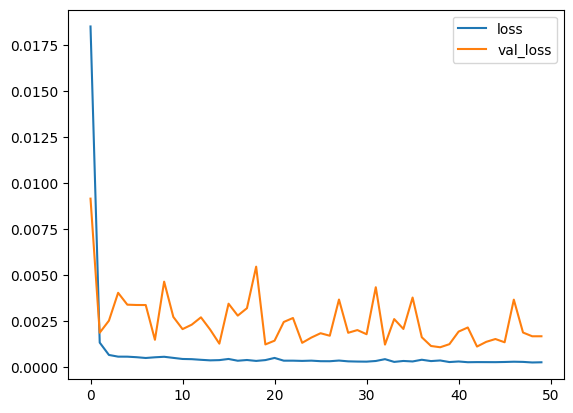

In [ ]:
# Show the learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

In [ ]:
# Make prediction with our model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

23/23 [==============================] - 3s 67ms/step


In [ ]:
# Transformback to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
# Calculate RMSE performance metrics
print("Trainning set error:",math.sqrt(mean_squared_error(y_train,train_predict)))
print("Testing set error:",math.sqrt(mean_squared_error(y_test,test_predict)))

Trainning set error: 47.66055365396834
Testing set error: 101.00362754095922


In [ ]:
df.shape

(2323, 2)

In [ ]:
price_df = df[:, 0:1]

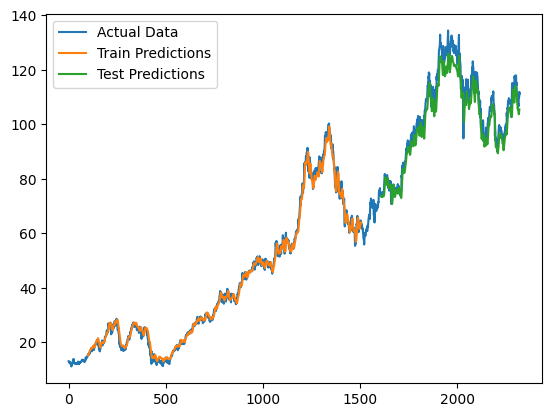

In [ ]:
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(price_df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(price_df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(price_df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(price_df), label='Actual Data')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.plot(testPredictPlot, label='Test Predictions')
plt.legend()
plt.show()

# Testing on second dataset

49/49 [==============================] - 2s 41ms/step
RMSE: 123.271105415388


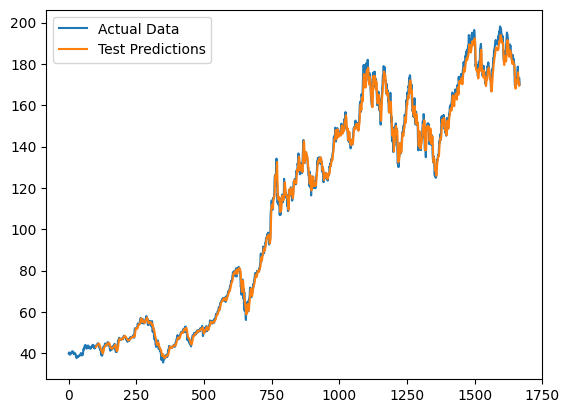

In [ ]:
# Testing on second data: We use Apple stock price from 2018 to 2024 to test
df1=pd.read_csv('AAPL.csv')

# Use Close value as our input
df1=df1.reset_index()['Close']

# Normalize the dataset
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

# Convert an array of values into a dataset matrix
X_test1 , y_test1 = create_dataset(df1, time_step)

# Reshape the arrays to have an additional dimension
X_test1 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1] , 1)

# Make prediction with model
test_predict1 = model.predict(X_test1)

# Transformback to original form
test_predict1 = scaler.inverse_transform(test_predict1)

# Calculate RMSE performance metrics
print("RMSE:",math.sqrt(mean_squared_error(y_test1,test_predict1)))

# Plot the prediction with actual value
testPredictPlot2 = np.empty_like(df1)
testPredictPlot2[:, :] = np.nan
testPredictPlot2[look_back:len(test_predict1)+look_back, :] = test_predict1
plt.plot(scaler.inverse_transform(df1), label='Actual Data')
plt.plot(testPredictPlot2, label='Test Predictions')
plt.legend()
plt.show()

# Test on third dataset

37/37 [==============================] - 1s 39ms/step
RMSE: 277.36549001077805


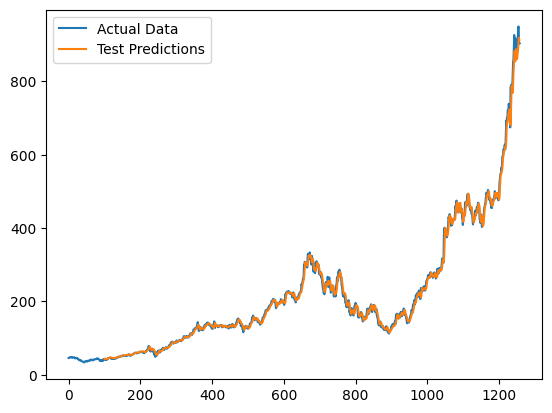

In [ ]:
# Testing on second data: We use Nvida stock price from 2019 to 2024 to test
df3=pd.read_csv('NVDA.csv')
df3=df3.reset_index()['Close'];
df3 = scaler.fit_transform(np.array(df3).reshape(-1,1));
X_test3, y_test3 = create_dataset(df3, time_step)
X_test3 = X_test3.reshape(X_test3.shape[0],X_test3.shape[1] , 1)
test_predict_3 = model.predict(X_test3)
test_predict_3 = scaler.inverse_transform(test_predict_3)
print("RMSE:",math.sqrt(mean_squared_error(y_test3,test_predict_3)))

testPredictPlot3 = np.empty_like(df3)
testPredictPlot3[:, :] = np.nan
testPredictPlot3[look_back:len(test_predict_3)+look_back, :] = test_predict_3
plt.plot(scaler.inverse_transform(df3), label='Actual Data')
plt.plot(testPredictPlot3, label='Test Predictions')
plt.legend()
plt.show()

# Demonstrate prediction for next 30 days

In [ ]:
# demonstrate prediction for next 30 days for Apple stock price
x_input = df1[1568:].reshape(1,-1) #len(test_data)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()
lst_output = []
n_steps = 100
i = 0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

print(lst_output)

[0.82841617]
101
[[0.8284161686897278], [0.8223759531974792], [0.8186420798301697], [0.8156600594520569], [0.8125604391098022], [0.8093294501304626], [0.8061402440071106], [0.8030651211738586], [0.800099790096283], [0.7972311973571777], [0.7944576144218445], [0.7917838096618652], [0.7892132997512817], [0.7867469191551208], [0.7843843102455139], [0.7821229100227356], [0.779959499835968], [0.7778891921043396], [0.7759067416191101], [0.7740060687065125], [0.7721807360649109], [0.7704234719276428], [0.7687283754348755], [0.7670882344245911], [0.7654977440834045], [0.7639502286911011], [0.7624407410621643], [0.7609645128250122], [0.7595171928405762], [0.758095383644104]]


In [ ]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

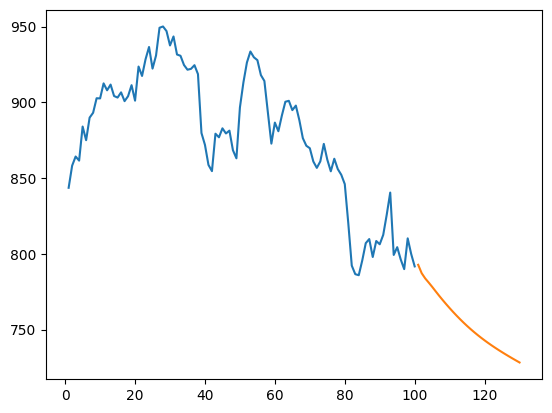

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[1568:])) #len(df1)
plt.plot(day_pred,scaler.inverse_transform(lst_output))

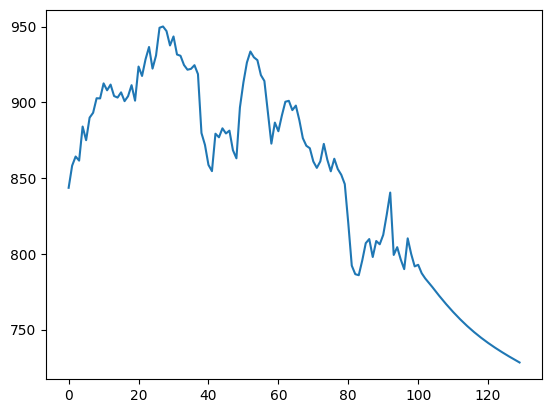

In [ ]:
df4 = df1.tolist()
df4.extend(lst_output)
df4 = scaler.inverse_transform(df4).tolist()
plt.plot(df4[1568:])

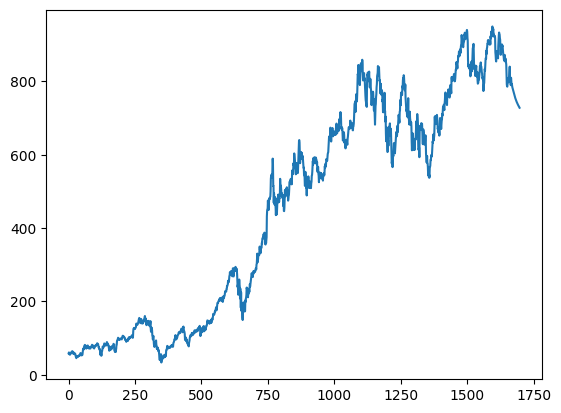

In [ ]:
plt.plot(df4)